# Программа «Практический анализ данных и машинное обучение»
## Анализ социальных сетей: Центральности, дескриптивные статистики на сетях

Преподаватели: Шестаков Андрей, Докукина София

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import Image, display

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
# Утилька для рисования графов с лейблами
def plot_graph(g, settings=dict()):
    ig.plot(g, 'graph.png', **settings)
    display(Image(filename='graph.png'))

# Node Similarities

Понятие **"эквивалетности"** вершин можно ославить до **"схожести"** вершин - некоторая мера структурной близости вершин. 

Наиболее распространенные практиеские применения мер сходства:
* Выявление сообществ
* Предсказание связей

## Примеры мер сходства

#### Jaccard Similarity
$$ s(v_i, v_j) = \frac{|N(v_i) \cap N(v_j)|}{|N(v_i) \cup N(v_j)|} $$

#### Cosine Similarity
$$ s(v_i, v_j) = \frac{\langle A_{i \cdot}, A_{j \cdot} \rangle}{\sqrt{\sum_k A^2_{ik}} \sqrt{\sum_k A^2_{jk}}} $$

#### Correlation
$$ s(v_i, v_j) = \frac{\sum_k (A_{ik} - \bar{A}_{i\cdot}) (A_{jk} - \bar{A}_{j\cdot})}{\sqrt{\sum_k (A_{ik} - \bar{A}_{i\cdot})^2} \sqrt{\sum_k (A_{jk} - \bar{A}_{j\cdot})^2}} $$

#### Adamic-Adar Score
$$ s(v_i, v_j) = \sum\limits_{z \in N(v_i) \cap N(v_j)} \frac{1}{\log(|N(z)|)} $$

#### Preferential Attachment Score
$$ s(v_i, v_j) = |N(v_i)| \cdot |N(v_j)| $$

#### Katz Score
$$ s(v_i, v_j) = \sum\limits_{l=1} \beta^l |\text{numPaths}(l, v_i, v_j)| $$

#### Задание
* Загрузите граф из `nested_partition.gml`. Это граф, построенный с помощью [генератора](https://sites.google.com/site/santofortunato/inthepress2) Benchmark сетей для тестов алгоритмов выявления сообществ.
* Визуализируйте матрицу смежности графа с помощью метода `plt.spy(A)` (и саму сеть, если получится)
* Рассчитайте реализованные в `igraph` меры схожести вершин: `similarity_jaccard` и `similarity_inverse_log_weighted`. Визуализируйте полученный результат

По большому счету, полученные схожести можно подавать на вход любому алгоритму кластеризации, который изначально может работать со мерами близости (например аггломеративная кластеризация)

In [3]:
g = ig.Graph.Read_GML('nested_partition.gml')

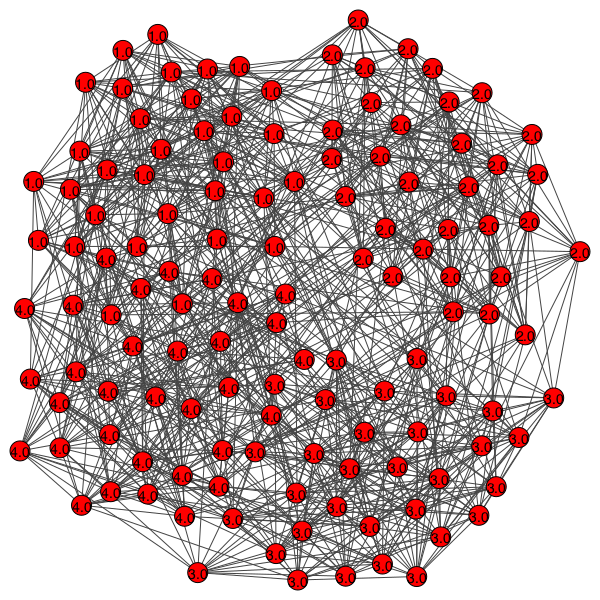

In [4]:
graph_layout = g.layout_fruchterman_reingold()
vision_settings = dict()
vision_settings['layout'] = graph_layout
plot_graph(g)

## Community Detection

### Оценка качества кластеризации при известном groud truth

#### Доля правильно кластеризованных вешин
Пусть $\hat{\pi}$ - это полученное разбиение на сообщества, а $\pi^*$ - ground truth. Тогда доля правильно угаданных меток рассчитывается как

$$ Acc(\hat{\pi}, \pi^*) = \frac{\text{# of correctly clustered obs}}{N} \text{,}$$
где вершина считается правильно кластеризованной, если **хотя бы половина** вершин из того же кластера в $\hat{\pi}$ относится к некоторому кластеру в $\pi^*$

#### Adjusted Rand Index

$$ \text{Rand}(\hat{\pi},\pi^*) = \frac{a + d}{a + b + c + d} \text{,}$$
где 
* $a$ количество пар вершин, находящихся в одинаковых кластерах в $\hat{\pi}$ и
$\pi^*$, 
* $b$ ($c$) количество пар вершин в одном и том же сообществе в  $\hat{\pi}$ ($\pi^*$), но в разных в  $\pi^*$ ($\hat{\pi}$)
* $d$ количество пар вершин в разных кластерах в $\hat{\pi}$ и $\pi^*$

Adjusted Rand Index - корректировка Rand index:

$$\text{ARI}(\hat{\pi},\pi^*)   = \frac{\text{Rand}(\hat{\pi},\pi^*) - \text{Expected}}{\text{Max} - \text{Expected}}$$

Так же есть **[Normalized Mutual Information](http://en.wikipedia.org/wiki/Mutual_information)**, но результаты этой метрики схожи с ARI

####  Задание
В igraph реализовано довольно много методов выявления сообществ. Все реализации начинаются с `community_`. 

* Выберите один из изученных на лекции алгоритмов и оцените его качество с помощью ARI.
* ARI реализовано в ig.compare_communities()

## Community label propagation

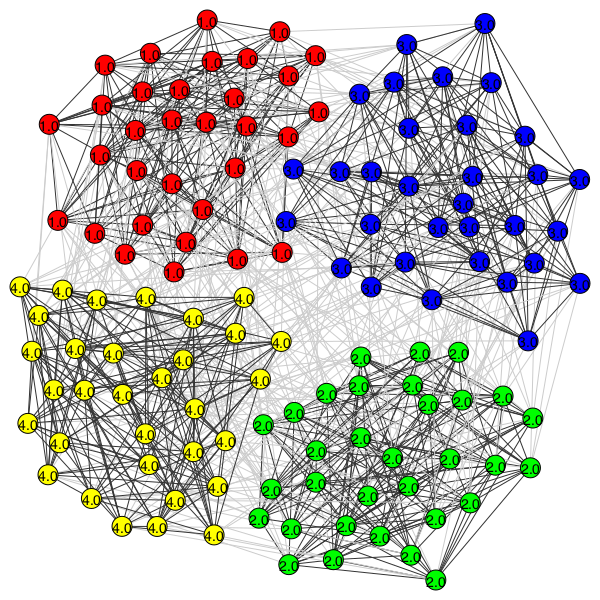

In [5]:
plot_graph(ig.Graph.community_label_propagation(g))

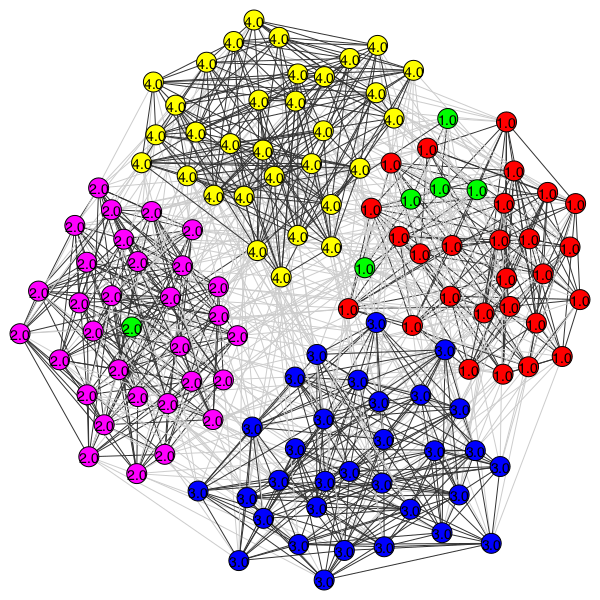

In [6]:
plot_graph(ig.Graph.community_leading_eigenvector(g))

In [ ]:
ig.Graph.

In [ ]:
plot_graph(ig.Graph.community_optimal_modularity(g))

### Меры качества кластеризации без ground truth

Как и в "табличной" кластеризации, качество community detection можно оценить и без ground truth. Для этого считают так называемые scoring functions.

Чего бы нам хотелось получить от выявленного сообщества (разбиения на сообщества):
* Плотности ребер внутри сообщества
* БОльшая доря ребер внутри сообщества относительно ребер, связывающих его с внешним миром
* Высокий коэффициент кластаризации внутри сообщества (относительно среднего по сети)
* Высокая модулярность $$ Q = \frac{1}{2m} \sum\limits_{ij}\left(A_{ij} - \frac{k_i k_j}{2m}\right)\delta(\mathcal{C}_i,\mathcal{C}_j), $$ где $\delta(\cdot,\cdot)$ - *дельта символ Кронекера*, а  $\mathcal{C}_i$ - метка кластера для вершини $v_i$.
* ...

В [статье](https://arxiv.org/pdf/1205.6233.pdf) можно найти наиболее полный набор так называемых scoring functions

#### Задание
Реализуйте и расчитайте данные scoring functions.

In [229]:
## Your Code Here

Сеть на основе вселенной Игры Престолов (spoiler alert!)

Рассмотрим две таблички: `characters.csv` и `events.csv`. Названия говорят сами за себя - в  `characters.csv` содержится информация о персонажах серии романов, а в `events.csv` описание событий. Мы будем рассматривать события, которыми славится Игры Престолов - убийства.

В первом файле, помимо индетификатора персонажа (`characterID`), нас будут интересовать поля имени (`Name`) и его группы (`Team`). <br/>
Во втором - события убийства  (`event = killed`) и поле с указанием убитого (`characterID`) и убийцы (`withID`)

#### Задание
* Постройте сеть (направленный граф) убийств персонажей. В каждой вершине должен быть сохранен атрибут имени и группы
* Переиндексируйте идентификаторы вершин начиная с `0` и проиндексируйте группы, тоже начиная с `0`. В функции `assortativity_nominal` требуется, чтобы атрибут был закодирован как число
* Посчитайте коэффициент ассортативности по отношению к атрибуту "группа", который в данном контексте можно интерпретировать как "склонность убивать своих". Проинтерпретируйте полученный результат